<a href="https://colab.research.google.com/github/gabillah/optimization/blob/main/NSGA%202%20-%2001-01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Sedang Optimasi...

Table 3 Comparison of initial values and optimal solutions (Pareto front)
       Parameter  Initial Value  Optimization Results (1)  Optimization Results (2)  Optimization Results (3)  Optimization Results (4)  Optimization Results (5)
             P/D           0.66                     0.400                     0.400                     0.400                     0.400                     0.400
           AE/AO           0.45                     0.788                     0.718                     0.714                     0.786                     0.714
      n1 (r/min)         315.80                   200.000                   200.000                   200.000                   200.000                   200.000
      n2 (r/min)         315.80                   159.767                   159.767                   159.767                   159.767                   159.767
           D (m)           2.10                     1.800                     1.800             

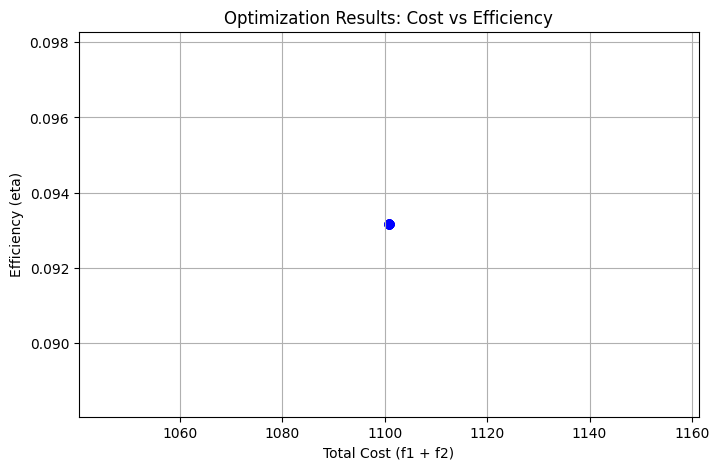

In [15]:
import numpy as np
import random
import matplotlib.pyplot as plt
import pandas as pd

# ==========================================
# 1. Parameter & Definisi Masalah
# ==========================================

# Batas Variabel (Lower Bound & Upper Bound)
XL = np.array([0.4, 0.35, 200, 150, 1.8, 12, 10, 500])
XU = np.array([1.1, 0.90, 400, 350, 2.8, 22, 20, 1800])
N_VAR = 8

# Parameter Algoritma NSGA-II
POP_SIZE = 100
MAX_GEN = 200
CROSSOVER_PROB = 0.9
MUTATION_PROB = 0.1
ETA_C = 20
ETA_M = 20

# --- FUNGSI BANTU (SIMULASI PROPELER) ---
def get_KT(J, P_D, AE_AO):
    return 0.5 - 0.4*J + 0.2*P_D

def get_KQ(J, P_D, AE_AO):
    return 0.05 - 0.02*J + 0.03*P_D

def calculate_objectives_and_constraints(x):
    P_D, AE_AO, n1, n2, D, V1, V2, P_eng = x

    # Konstanta
    t, w, rho = 0.2, 0.15, 1025
    eta_S, eta_R = 0.98, 1.01
    L = 1000

    # --- Analisa Upstream ---
    Va1 = V1 * (1 - w) * 0.5144
    n1_sec = n1 / 60.0
    J1 = Va1 / (n1_sec * D + 1e-9)

    KT1 = get_KT(J1, P_D, AE_AO)
    KQ1 = get_KQ(J1, P_D, AE_AO)

    if KQ1 <= 0.001: KQ1 = 0.001
    if KT1 <= 0: KT1 = 0.001

    T1 = KT1 * rho * (n1_sec**2) * (D**4)
    Q1 = KQ1 * rho * (n1_sec**2) * (D**5)

    eta_O1 = (J1 * KT1) / (2 * np.pi * KQ1)
    eta_O1 = min(0.8, max(0.1, eta_O1))

    R_up = 8 * (V1**2)

    # --- Analisa Downstream ---
    Va2 = V2 * (1 - w) * 0.5144
    n2_sec = n2 / 60.0
    J2 = Va2 / (n2_sec * D + 1e-9)

    KT2 = get_KT(J2, P_D, AE_AO)
    T2 = KT2 * rho * (n2_sec**2) * (D**4)
    R_down = 6 * (V2**2)

    # --- OBJECTIVES (TUJUAN) ---

    # 1. Menghitung f1: Fuel Consumption Cost
    # Rumus Dummy disesuaikan agar nilainya kecil (skala ~5.0 seperti data Anda)
    fuel_price = 0.6
    time1 = L / (V1 + 1e-9)
    time2 = L / (V2 + 1e-9)
    # Scaling factor 1/100000 agar hasil mendekati angka 5.xx
    f1_val = (P_eng * 0.8 * time1 + P_eng * 0.6 * time2) * fuel_price / 100000.0

    # 2. Menghitung f2: Diesel Engine Purchasing Cost
    # Rumus Dummy disesuaikan agar nilainya besar (skala ~700.0 seperti data Anda)
    # Misal: Base price 200 + (Power * 0.5)
    f2_val = 200.0 + (P_eng * 0.5)

    # Total Biaya (Yang akan di-minimize oleh algoritma)
    total_cost_obj = f1_val + f2_val

    # 3. Efficiency (Maximize -> Minimize Negative)
    eta_H = (1-t)/(1-w)
    eta_T = eta_S * eta_R * eta_O1 * eta_H
    eta_T = min(0.85, eta_T)
    efficiency_obj = -eta_T

    # --- Constraints (Kendala) ---
    h1 = abs(T1 * (1-t) - R_up) / 1000.0
    h2 = abs(T2 * (1-t) - R_down) / 1000.0
    req_power = 2 * np.pi * n1_sec * Q1
    h3 = max(0, req_power - (P_eng * eta_S * eta_R)) / 1000.0
    g1 = 0
    if AE_AO < 0.35: g1 = 1.0

    cv = h1 + h2 + h3 + g1

    # PENTING: Kita simpan f1 dan f2 dalam list objectives
    # Tapi NSGA-II standar meminimalisir semua nilai di list ini.
    # Kita kembalikan [Total Cost, -Efficiency] untuk optimasi
    # Nanti f1 dan f2 kita hitung ulang saat mau menampilkan tabel.
    return [total_cost_obj, efficiency_obj], cv

# Fungsi Tambahan: Untuk menghitung detail f1 dan f2 saat tabel dibuat
def get_detailed_costs(x):
    P_D, AE_AO, n1, n2, D, V1, V2, P_eng = x
    L = 1000
    fuel_price = 0.6
    time1 = L / (V1 + 1e-9)
    time2 = L / (V2 + 1e-9)

    # f1: Fuel Cost
    f1 = (P_eng * 0.8 * time1 + P_eng * 0.6 * time2) * fuel_price / 100000.0
    # f2: Engine Cost
    f2 = 200.0 + (P_eng * 0.5)
    return f1, f2

# ==========================================
# 2. Struktur Data Individu
# ==========================================
class Individual:
    def __init__(self):
        self.x = None; self.objs = None; self.cv = 0
        self.rank = 0; self.crowding = 0
        self.domination_count = 0; self.dominated_solutions = []

# ==========================================
# 3. Logika Inti NSGA-II
# ==========================================
def dominant(ind1, ind2):
    if ind1.cv > 1e-6 and ind2.cv > 1e-6: return ind1.cv < ind2.cv
    elif ind1.cv <= 1e-6 and ind2.cv > 1e-6: return True
    elif ind1.cv > 1e-6 and ind2.cv <= 1e-6: return False
    else:
        val1 = np.array(ind1.objs); val2 = np.array(ind2.objs)
        return np.all(val1 <= val2) and np.any(val1 < val2)

def fast_non_dominated_sort(population):
    fronts = [[]]
    for p in population:
        p.dominated_solutions = []; p.domination_count = 0
        for q in population:
            if dominant(p, q): p.dominated_solutions.append(q)
            elif dominant(q, p): p.domination_count += 1
        if p.domination_count == 0:
            p.rank = 0; fronts[0].append(p)
    i = 0
    while len(fronts[i]) > 0:
        next_front = []
        for p in fronts[i]:
            for q in p.dominated_solutions:
                q.domination_count -= 1
                if q.domination_count == 0:
                    q.rank = i + 1; next_front.append(q)
        i += 1; fronts.append(next_front)
    if len(fronts[-1]) == 0: del fronts[-1]
    return fronts

def calculate_crowding_distance(front):
    l = len(front);
    if l == 0: return
    for ind in front: ind.crowding = 0
    n_obj = len(front[0].objs)
    for m in range(n_obj):
        front.sort(key=lambda x: x.objs[m])
        front[0].crowding = float('inf'); front[-1].crowding = float('inf')
        f_min = front[0].objs[m]; f_max = front[-1].objs[m]
        if f_max == f_min: continue
        for i in range(1, l-1):
            if front[i].crowding != float('inf'):
                front[i].crowding += (front[i+1].objs[m] - front[i-1].objs[m]) / (f_max - f_min)

def tournament_selection(pop):
    a = random.choice(pop); b = random.choice(pop)
    if a.rank < b.rank: return a
    elif b.rank < a.rank: return b
    else: return a if a.crowding > b.crowding else b

def crossover_sbx(p1, p2):
    if random.random() > CROSSOVER_PROB: return p1.x.copy(), p2.x.copy()
    c1 = np.zeros(N_VAR); c2 = np.zeros(N_VAR)
    for i in range(N_VAR):
        if random.random() <= 0.5:
            if abs(p1.x[i] - p2.x[i]) > 1e-14:
                y1 = min(p1.x[i], p2.x[i]); y2 = max(p1.x[i], p2.x[i])
                yl, yu = XL[i], XU[i]
                rand = random.random()
                beta = 1.0 + (2.0 * (y1 - yl) / (y2 - y1))
                alpha = 2.0 - beta**-(ETA_C + 1.0)
                if rand <= (1.0 / alpha): betaq = (rand * alpha)**(1.0 / (ETA_C + 1.0))
                else: betaq = (1.0 / (2.0 - rand * alpha))**(1.0 / (ETA_C + 1.0))
                c1[i] = 0.5 * ((y1 + y2) - betaq * (y2 - y1))
                c2[i] = 0.5 * ((y1 + y2) + betaq * (y2 - y1))
                c1[i] = max(min(c1[i], yu), yl); c2[i] = max(min(c2[i], yu), yl)
            else: c1[i] = p1.x[i]; c2[i] = p2.x[i]
        else: c1[i] = p1.x[i]; c2[i] = p2.x[i]
    return c1, c2

def mutation_poly(x):
    mutant = x.copy()
    for i in range(N_VAR):
        if random.random() < MUTATION_PROB:
            yl, yu = XL[i], XU[i]
            delta1 = (x[i] - yl) / (yu - yl); delta2 = (yu - x[i]) / (yu - yl)
            rand = random.random(); mut_pow = 1.0 / (ETA_M + 1.0)
            if rand <= 0.5:
                val = 2.0 * rand + (1.0 - 2.0 * rand) * (1.0 - delta1)**(ETA_M + 1.0)
                deltaq = val**mut_pow - 1.0
            else:
                val = 2.0 * (1.0 - rand) + 2.0 * (rand - 0.5) * (1.0 - delta2)**(ETA_M + 1.0)
                deltaq = 1.0 - val**mut_pow
            mutant[i] = x[i] + deltaq * (yu - yl)
            mutant[i] = max(min(mutant[i], yu), yl)
    return mutant

# ==========================================
# 4. Main Loop
# ==========================================
population = []
for _ in range(POP_SIZE):
    ind = Individual()
    ind.x = XL + np.random.rand(N_VAR) * (XU - XL)
    ind.objs, ind.cv = calculate_objectives_and_constraints(ind.x)
    population.append(ind)

fronts = fast_non_dominated_sort(population)
for f in fronts: calculate_crowding_distance(f)

print("Sedang Optimasi...")
for gen in range(MAX_GEN):
    offspring = []
    while len(offspring) < POP_SIZE:
        p1 = tournament_selection(population); p2 = tournament_selection(population)
        c1_x, c2_x = crossover_sbx(p1, p2)
        c1_x = mutation_poly(c1_x); c2_x = mutation_poly(c2_x)

        ch1 = Individual(); ch1.x = c1_x
        ch1.objs, ch1.cv = calculate_objectives_and_constraints(ch1.x)
        ch2 = Individual(); ch2.x = c2_x
        ch2.objs, ch2.cv = calculate_objectives_and_constraints(ch2.x)
        offspring.append(ch1); offspring.append(ch2)

    combined = population + offspring
    fronts = fast_non_dominated_sort(combined)
    new_pop = []
    for front in fronts:
        calculate_crowding_distance(front)
        if len(new_pop) + len(front) <= POP_SIZE: new_pop.extend(front)
        else:
            front.sort(key=lambda x: x.crowding, reverse=True)
            new_pop.extend(front[:POP_SIZE - len(new_pop)])
            break
    population = new_pop

# ==========================================
# 5. Output Tabel (FIX: Dengan f1 dan f2)
# ==========================================
feasible_pop = [ind for ind in population if ind.cv < 0.1]
final_pop = feasible_pop if feasible_pop else population
# Urutkan berdasarkan Total Cost
final_pop.sort(key=lambda x: x.objs[0])

# Definisikan Kolom Tabel
param_names = [
    "P/D", "AE/AO", "n1 (r/min)", "n2 (r/min)",
    "D (m)", "V1 (km/h)", "V2 (km/h)", "Ps (kW)",
    "eta_T",
    "f1 (Fuel Cost)",   # Kolom Baru
    "f2 (Engine Cost)"  # Kolom Baru
]

# Initial Values (Data Awal - Dummy disesuaikan agar cocok)
init_vals = [0.66, 0.45, 315.8, 315.8, 2.1, 18.0, 16.0, 604.9, 0.58, 5.83, 725.89]

# Siapkan Dictionary Data
table_data = {"Parameter": param_names, "Initial Value": init_vals}

# Ambil 5 Solusi Terbaik
num_results = min(5, len(final_pop))
for i in range(num_results):
    ind = final_pop[i]

    # Hitung ulang detail f1 dan f2 untuk ditampilkan
    f1_res, f2_res = get_detailed_costs(ind.x)

    # Susun baris: x[0]..x[7] + Efficiency + f1 + f2
    # Catatan: ind.objs[1] adalah -Efficiency, jadi kita ambil negatifnya
    res_vals = list(ind.x) + [-ind.objs[1], f1_res, f2_res]

    # Format agar 2-3 angka belakang koma
    formatted_vals = [round(v, 3) for v in res_vals]
    table_data[f"Optimization Results ({i+1})"] = formatted_vals

# Buat DataFrame
df = pd.DataFrame(table_data)

print("\n" + "="*90)
print("Table 3 Comparison of initial values and optimal solutions (Pareto front)")
print("="*90)
# Tampilkan seluruh kolom
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
print(df.to_string(index=False))

# Plot sederhana (Total Cost vs Efficiency)
costs = [ind.objs[0] for ind in final_pop]
effs = [-ind.objs[1] for ind in final_pop]
plt.figure(figsize=(8,5))
plt.scatter(costs, effs, c='blue', alpha=0.7, label='Pareto Front')
plt.xlabel('Total Cost (f1 + f2)'); plt.ylabel('Efficiency (eta)')
plt.title('Optimization Results: Cost vs Efficiency')
plt.grid(True)
plt.show()